# Obesity Level Prediction (UCI 544)

## Goal
Predict the obesity level category (`NObeyesdad`) using eating habits and physical condition features.

## Metrics
Primary: Macro F1-score  
Secondary: Accuracy

## Load the Dataset

We load the dataset directly from the UCI Machine Learning Repository using the `ucimlrepo` package.  


In [7]:
import pandas as pd 
import numpy as np

from ucimlrepo import fetch_ucirepo

# Fetch dataset (UCI ID 544)
obesity = fetch_ucirepo(id=544)

X = obesity.data.features
y = obesity.data.targets

print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (2111, 16)
y shape: (2111, 1)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II


## Combine Features and Target

For exploratory data analysis (EDA), it is convenient to work with a single DataFrame  
that includes both features and the target variable.

This makes it easier to:
- inspect target distribution
- analyze feature–target relationships
- visualize patterns


In [8]:
df = X.copy()
df["NObeyesdad"] = y.iloc[:, 0]

print("Combined DataFrame shape:", df.shape)
print("\nColumn names:")
print(df.columns)

print("\nTarget class distribution:")
print(df["NObeyesdad"].value_counts())


Combined DataFrame shape: (2111, 17)

Column names:
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

Target class distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


## Inspect Data Types and Missing Values

Before any preprocessing or modeling, it is critical to understand:
- which features are numeric vs categorical
- whether missing values are present

This informs:
- encoding strategies
- imputation choices
- pipeline design


In [9]:
print("Data types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nAny missing values in dataset?")
print(df.isna().any().any())


Data types:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Missing values per column:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC            

## Initial Observations

From the initial inspection:

- The dataset contains **2,111 observations** and **17 columns**  
  (16 feature variables and 1 target variable).
- The target variable **`NObeyesdad`** represents a **7-class multi-class classification problem**.
- The class distribution is relatively balanced across obesity categories, with no extreme class imbalance.
- No missing values are present in the dataset, consistent with the dataset documentation.
- The feature set includes a mix of:
  - **Continuous numeric features** (e.g., Age, Height, Weight)
  - **Discrete numeric features** (e.g., FCVC, TUE)
  - **Binary categorical features** encoded as strings (e.g., yes/no)
  - **Multi-class categorical features** (e.g., CAEC, CALC, MTRANS)

These observations inform the preprocessing strategy used later, including feature scaling for numeric variables and one-hot encoding for categorical variables.



## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand:
- the distribution of the target variable
- basic characteristics of numeric features
- potential relationships that may influence modeling decisions

The goal is to gain intuition while avoiding over-analysis.

### Target Variable Distribution

Understanding the distribution of obesity level classes is important for:
- choosing appropriate evaluation metrics
- identifying potential class imbalance
- motivating the use of macro-averaged metrics


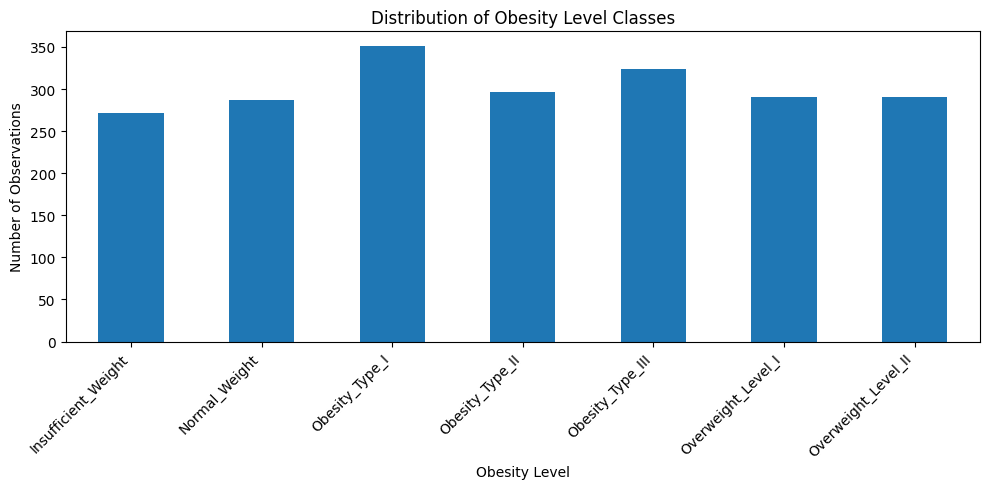

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df["NObeyesdad"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Obesity Level Classes")
plt.xlabel("Obesity Level")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Numeric Feature Summary

Next we examine summary statistics for numeric features to understand:
- scale differences
- potential outliers
- whether feature scaling will be necessary


In [11]:
numeric_cols = df.select_dtypes(include="number").columns

df[numeric_cols].describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Correlation Between Numeric Features

Correlation analysis helps identify:
- highly correlated variables
- redundant information
- features that may benefit from regularization or tree-based models


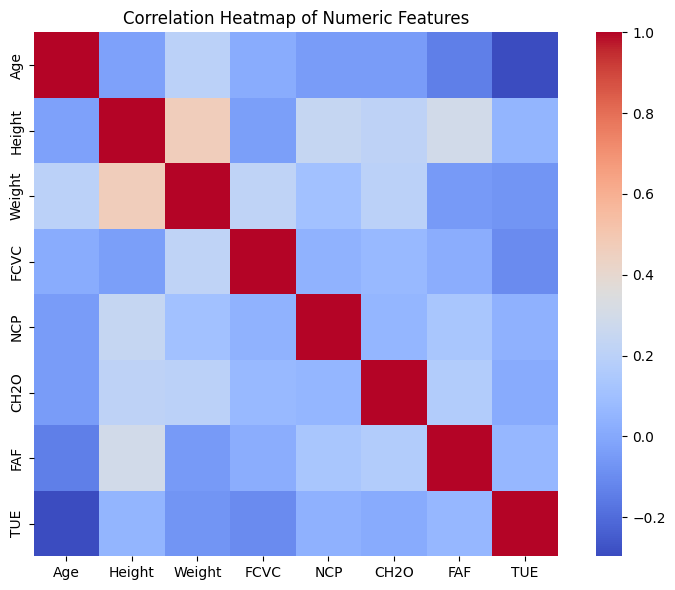

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=False,
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


## EDA Takeaways

Key insights from the exploratory analysis:

- The target variable (`NObeyesdad`) is **fairly well balanced** across the seven obesity categories, with each class containing roughly 270–350 observations.  
  This supports the use of **macro-averaged evaluation metrics** such as Macro F1-score.

- Numeric features exhibit **substantially different scales**:
  - Age ranges from 14 to 61
  - Height ranges roughly from 1.45 to 1.98
  - Weight ranges from 39 to 173  
  This confirms that **feature scaling is necessary**, particularly for distance-based or linear models.

- Correlation analysis shows:
  - A **moderate positive correlation** between Height and Weight
  - Generally **low to moderate correlations** among most other numeric features  
  This suggests limited multicollinearity overall, while still indicating that some regularization may be beneficial.

- The combination of mixed feature types (numeric, binary categorical, multi-class categorical) and modest correlations motivates:
  - the use of a `ColumnTransformer` for preprocessing
  - comparison of both **regularized linear models** and **tree-based models**, which can capture non-linear relationships without heavy feature interaction engineering.
